In [1]:
import pandas as pd 
from pandas import Series
import numpy as np 
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.api import qqplot  
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX 

import pmdarima as pm
from pmdarima import auto_arima 
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import nsdiffs
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn import datasets

# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
#Importing data
Chengdu = pd.read_csv("D:/Math546 Time series/final projects/PM2.5 Data of Five Chinese Cities Data Set/ChengduPM20100101_20151231.csv")
#Chengdu

In [3]:
#Delet non-useful data
Chengdu.drop(['PM_Caotangsi', 'PM_Shahepu', 'season', 'precipitation', 'Iprec'], 
               axis=1,
              inplace=True)

In [4]:
Chengdu.dropna(axis=0, how="any",inplace=True)

In [5]:
# from datetime import datetime
Chengdu['Time'] = pd.to_datetime(Chengdu['year'].map(str) +"/"+ Chengdu['month'].map(str) +"/"+ Chengdu['day'].map(str)+" "+Chengdu['hour'].map(str)+":00:00")
#Beijing

In [6]:
Chengdu.groupby(['year']).size()

year
2012    4405
2013    6893
2014    8467
2015    8630
dtype: int64

In [7]:
by_hour = Chengdu.groupby(['Time']).mean()
#by_hour.head()

In [8]:
by_hour.index = pd.to_datetime(by_hour.index, 
                             format='%d-%m-%Y %H:%M:%S')
by_hour = by_hour.set_index(by_hour.index).asfreq('H')
by_hour = by_hour.fillna(method='ffill')

#print(by_hour.index)

In [9]:
by_hour['Time'] = by_hour.index
#by_hour['Time']

In [10]:
data_13 = by_hour[(by_hour['Time'] >=pd.to_datetime('20140101030000')) & (by_hour['Time'] <= pd.to_datetime('20151231030000'))]

In [11]:
data_13 = data_13.set_index(data_13.index).asfreq('d')
data_13 = data_13.fillna(method='ffill')
#data_13

In [12]:
#data_13.to_csv(r'D:/Math546 Time series/project/Prep_FiveCitiePMData_MEAN/ChengduPM_cleaned.csv')

In [13]:
data = by_hour[(by_hour['Time'] >=pd.to_datetime('20130101030000')) & (by_hour['Time'] <= pd.to_datetime('20130201030000'))]
data = data.set_index(data.index).asfreq('d')
data = data.fillna(method='ffill')
#data

In [14]:
# take aDFuller test the statioinarity of  the timeseries
def test_stationarity(timeseries):
 #Determing rolling statistics
    rolmean=pd.Series.rolling(timeseries,window=12).mean()
 #rolmean=pd.rolling_mean(timeseries,window=12)
 #rolstd=pd.rolling_std(timeseries,window=12)
    rolstd=pd.Series.rolling(timeseries,window=12).std()
 
 #plot rolling statistics
    orig=plt.plot(timeseries,color='blue',label='Original')
    mean=plt.plot(rolmean,color='red',label='Rolling mean')
    std=plt.plot(rolstd,color='black',label='Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling mean & Standard Deviatiom')
    plt.show(block=False)
 
 #perfprmance Dickey_Fuller Test
    print('Resluts of Dickey-Fuller Test:')
    dftest=adfuller(timeseries,autolag='AIC')
    dfountput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','Number of obervations used'])
 
    for key,value in dftest[4].items():
        dfountput['Critical Value(%s)'%key]=value      
    print(dfountput)
# 

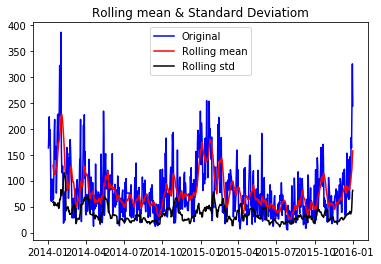

Resluts of Dickey-Fuller Test:
Test Statistic               -6.911715e+00
p-value                       1.207652e-09
#lags used                    3.000000e+00
Number of obervations used    7.260000e+02
Critical Value(1%)           -3.439389e+00
Critical Value(5%)           -2.865529e+00
Critical Value(10%)          -2.568894e+00
dtype: float64


In [15]:
test_stationarity(data_13['PM_US Post'])

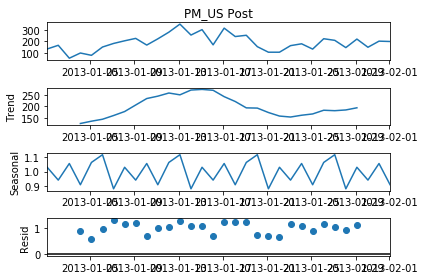

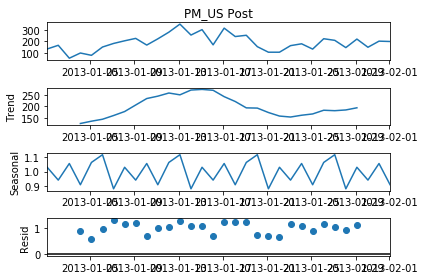

In [16]:
result = seasonal_decompose(data['PM_US Post'],  
                            model ='multiplicative') 
  
# ETS plot  
result.plot()

In [17]:
len(data_13)

730

In [18]:
# Split data into train / test sets 
train = data_13['PM_US Post'].iloc[:len(data_13)-156] 
test = data_13['PM_US Post'].iloc[len(data_13)-156:]

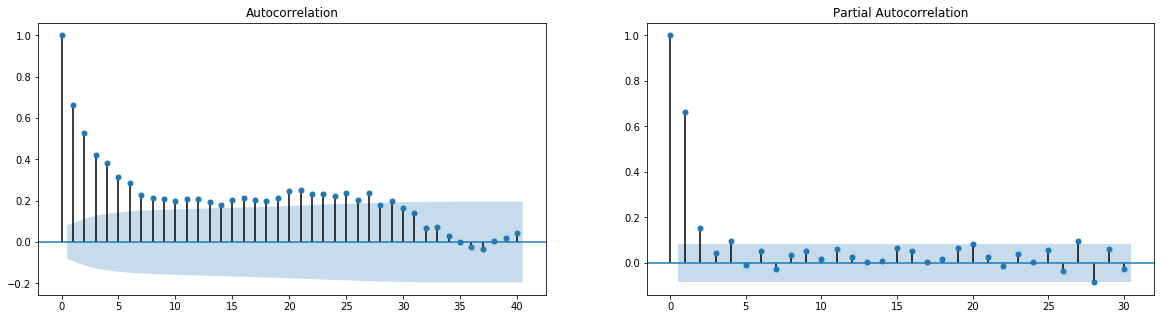

In [19]:
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig, axes = plt.subplots(1,2, figsize=(20,5))
plot_acf(train, lags=40, ax=axes[0], fft=False)
plot_pacf(train, lags=30, ax=axes[1])
plt.show()

In [20]:
# Fit auto_arima function to dataset 
stepwise_fit = auto_arima(train, start_p = 0, start_q = 0, 
                          max_p = 4, max_q = 9, m=52,
                          start_P = 0, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise  

Performing stepwise search to minimize aic
Fit ARIMA: (0, 0, 0)x(0, 1, 1, 52) (constant=True); AIC=5738.689, BIC=5751.462, Time=26.144 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 52) (constant=True); AIC=5898.611, BIC=5907.126, Time=0.774 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 52) (constant=True); AIC=5548.071, BIC=5565.102, Time=39.458 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 52) (constant=True); AIC=5559.539, BIC=5576.570, Time=61.414 seconds
Near non-invertible roots for order (0, 0, 1)(0, 1, 1, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 52) (constant=False); AIC=5906.370, BIC=5910.628, Time=0.559 seconds
Fit ARIMA: (1, 0, 0)x(0, 1, 0, 52) (constant=True); AIC=5689.295, BIC=5702.068, Time=5.168 seconds
Fit ARIMA: (1, 0, 0)x(2, 1, 0, 52) (constant=True); AIC=5499.662, BIC=5520.950, Time=135.688 seconds
Fit ARIMA: (1, 0, 0)x(2, 1, 1, 52) (constant=True); AIC=5443.375, BIC=5468.921, Time=293.502 second

In [21]:
# To print the summary 
stepwise_fit.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  574
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 52)   Log Likelihood               -2707.153
Date:                            Tue, 14 Apr 2020   AIC                           5426.306
Time:                                    17:30:23   BIC                           5451.852
Sample:                                         0   HQIC                          5436.312
                                            - 574                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.7471      0.409     -1.829      0.067      -1.548       0.054
ar.L1          0.8252      0.030     27.499      0.000       0.766       0.884
ma.L1         -0.2928      0.055     -5.290      0.000      -0.401      -0.184
ar.S.L52      -0.0748      0.059     -1.265      0.206      -0.191       0.041
ma.S.L52      -0.9984      7.822     -0.128      0.898     -16.330      14.333
sigma2      1455.9798   1.14e+04      0.128      0.898   -2.08e+04    2.37e+04
===================================================================================
Ljung-Box (Q):                       51.10   Jarque-Bera (JB):                95.12
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
# Fit a SARIMAX(1, 0, 1)x(1, 1, 1, 52)on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(train,  
                order = (1, 0, 1),  
                seasonal_order =(1, 1, 1, 52))

In [23]:
result = model.fit() 

In [24]:
 result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         PM_US Post   No. Observations:                  574
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 52)   Log Likelihood               -2709.254
Date:                            Tue, 14 Apr 2020   AIC                           5428.508
Time:                                    17:32:46   BIC                           5449.796
Sample:                                01-01-2014   HQIC                          5436.846
                                     - 07-28-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8425      0.029     29.134      0.000       0.786       0.899
ma.L1         -0.3043      0.053     -5.719      0.000      -0.409      -0.200
ar.S.L52      -0.0772      0.059     -1.300      0.193      -0.193       0.039
ma.S.L52      -0.9980      6.374     -0.157      0.876     -13.490      11.494
sigma2      1467.9957   9319.722      0.158      0.875   -1.68e+04    1.97e+04
===================================================================================
Ljung-Box (Q):                       49.11   Jarque-Bera (JB):                93.07
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

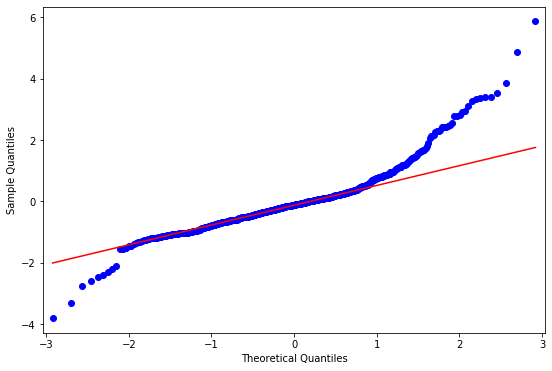

In [25]:
resid = result.resid
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
qqplot(resid, line='q', ax=ax, fit=True)
plt.show()

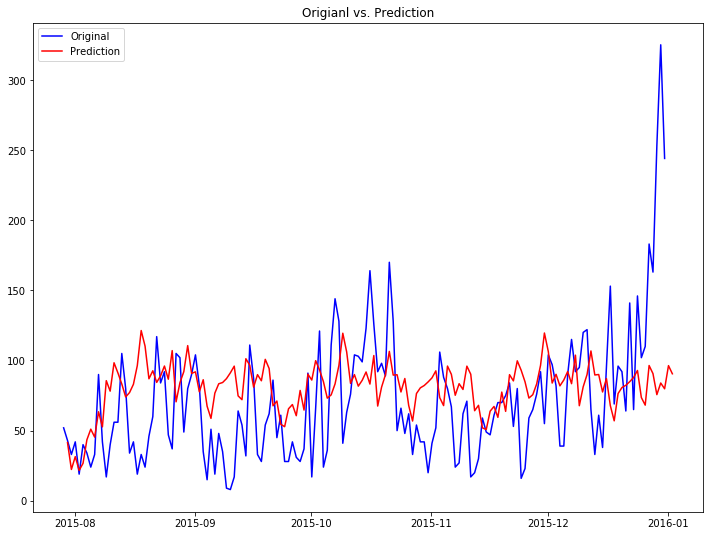

In [28]:
predict_ARMA = result.predict(start =575, end = 731) 
#print(predict_ARIMA) 

plt.figure(figsize=(12,9)) 
orig = plt.plot(test, color='blue', label='Original') 
pred = plt.plot(predict_ARMA, color='red', label='Prediction' ) 
plt.legend(loc='best') 
plt.title('Origianl vs. Prediction') 
plt.show(block=False) 